## Inputs & Constants

In [0]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import os
import random
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import time
import scipy

In [0]:
from google.colab import drive
GOOGLE_DRIVE_MOUNT = "/content/gdrive"
drive.mount(GOOGLE_DRIVE_MOUNT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
IMG_SIZE = 224
NUM_CLASSES = 10
DATA_DIR = 'impressionist-classifier-data/'
TRAIN_DIR = '/content/training/training/'
VALID_DIR = '/content/validation/validation/'

## Loading paintings dataset

In [0]:
# download test set          delayedkarma/impressionist-classifier-data
! KAGGLE_USERNAME='treacker' KAGGLE_KEY="96f527007b88ca0a90d1de4cc12e58d4" kaggle datasets download -d nulldata/medium-post-titles 

 65% 5.00M/7.70M [00:00<00:00, 13.9MB/s]
100% 7.70M/7.70M [00:00<00:00, 19.5MB/s]


In [0]:
from zipfile import ZipFile
with ZipFile("/content/medium-post-titles.zip", 'r') as zipObj:
   zipObj.extractall()

In [0]:
data = pd.read_csv('medium_post_titles.csv')

In [0]:
data.head()

,category,title,subtitle,subtitle_truncated_flag
0,work,"""21 Conversations"" - A fun (and easy) game for...",A (new?) Icebreaker game to get your team to s...,False
1,spirituality,"""Biblical Porn"" at Mars Hill",Author and UW lecturer Jessica Johnson talks a...,False
2,lgbtqia,"""CISGENDER?! Is That A Disease?!""","Or, a primer in gender vocabulary for the curi...",False
3,equality,"""Call me Nat Love"" :Black Cowboys and the Fron...",NaN,False
4,artificial-intelligence,"""Can I Train my Model on Your Computer?""",How we waste computational resources and how t...,False


In [0]:
data.describe()

,category,title,subtitle,subtitle_truncated_flag
count,126418,126418,124931,126418
unique,93,126095,122191,2
top,culture,DisruptED TV Magazine,Introduction,False
freq,5070,7,187,83029


In [0]:
data.fillna('', inplace=True)

data.subtitle_truncated_flag[data.subtitle_truncated_flag == False] = 0
data.subtitle_truncated_flag[data.subtitle_truncated_flag == True] = 1



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [0]:
data['title_subtitle'] = data['title'].str[:] + ' ' + data['subtitle'].str[:]

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['title_subtitle']], data['category'])


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1, 1))
tf_idf.fit(data['title_subtitle'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [0]:
count = CountVectorizer(ngram_range=(1, 1))
count.fit(data['title_subtitle'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [0]:
X_train_tf_idf = tf_idf.transform(X_train['title_subtitle'])
X_test_tf_idf = tf_idf.transform(X_test['title_subtitle'])

In [0]:
X_train_tf_idf.shape

(94813, 70091)

In [0]:
X_test_tf_idf.shape

(31605, 70091)

In [0]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

le.fit(y_train)
y_train_enc = le.transform(y_train)
y_test_enc = le.transform(y_test)

In [0]:
NUM_CLASSES = len(np.unique(y_train_enc))

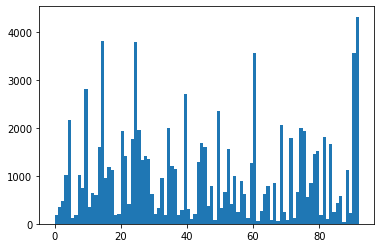

In [0]:
plt.hist(y_train_enc, bins=92)
plt.show()

In [0]:
import scipy.stats
import scipy.linalg
from scipy.spatial import distance_matrix

class RandomFourierFeatures:
    def __init__(self, n_features=1000, kernel='gaussian', orthogonal=False, regcoef=1.0,
                 inner_bias=True, estimate_rate=0.2, estimate_mode='mean'):
        self.n_features = n_features
        self.orthogonal = orthogonal
        self.regcoef = regcoef
        self.inner_bias = inner_bias
        self.estimate_rate = estimate_rate

        if kernel == 'gaussian':
            self.distr = scipy.stats.norm
        elif kernel == 'laplacian':
            self.distr = scipy.stats.cauchy
        elif kernel == 'cauchy':
            self.distr = scipy.stats.laplace
        else:
            raise ValueError('Unsupported kernel type')

        if estimate_mode == 'mean':
            self.estimator = np.mean
        elif estimate_mode == 'median':
            self.estimator = np.median

    def fit(self, X, y=None):
        rand_indices = np.random.choice([True, False], size=X.shape[0],
                                        p=[self.estimate_rate, 1 - self.estimate_rate])
        
        distances = distance_matrix(X[rand_indices], X[rand_indices])
        scale = self.regcoef / self.estimator(distances)

        if not self.orthogonal:
            self.W = self.distr.rvs(scale=scale, size=(X.shape[1], self.n_features))
        else:
            self.W = None
            while self.W is None or self.W.shape[1] < self.n_features:
                G = scipy.stats.norm.rvs(size=(X.shape[1], X.shape[1]))
                Q, _ = scipy.linalg.qr(G)
                norm_matrix = self.distr.rvs(size=(X.shape[1], X.shape[1]))
                norm_diag = np.sqrt(np.sum(norm_matrix ** 2, axis=0))
                weights = (scale * np.diag(norm_diag) @ Q).T

                if self.W is None:
                    cols = min(X.shape[1], self.n_features)
                    self.W = weights[:, :cols]
                else:
                    cols = min(X.shape[1], self.n_features - self.W.shape[1])
                    self.W = np.concatenate((self.W, weights[:, :cols]), axis=1)

        if self.inner_bias:
            self.b = scipy.stats.uniform.rvs(loc=-np.pi, scale=2 * np.pi, size=self.n_features)

    def transform(self, X):
        if self.inner_bias:
            X_trans = np.sqrt(2 / self.n_features) * np.cos(X @ self.W + self.b)
        else:
            X_trans = X @ self.W
            X_trans[:, :self.n_features // 2] = np.cos(X_trans[:, :self.n_features // 2])
            X_trans[:, self.n_features // 2:] = np.sin(X_trans[:, :self.n_features // 2])
            X_trans /= np.sqrt(self.n_features)
        
        return X_trans




In [0]:

model = LogisticRegression(tol=5 * 1e-5, dual=False)
start = time.time()
model.fit(X_train_tf_idf, y_train)

y_pred_train = model.predict(X_train_tf_idf)
print('time ', time.time() - start)
print('Train accuracy:', accuracy_score(y_train, y_pred_train))
y_pred_test = model.predict(X_test_tf_idf)
print('Test accuracy:', accuracy_score(y_test, y_pred_test))

[LibLinear]time  373.72938084602356
Train accuracy: 0.9929334584919789
Test accuracy: 0.3834519854453409


In [0]:
pca = TruncatedSVD(n_components=100).fit(X_train_tf_idf)
X_trans_train = pca.transform(X_train_tf_idf)

pca = TruncatedSVD(n_components=100).fit(X_test_tf_idf)
X_trans_test = pca.transform(X_test_tf_idf)

In [0]:
rff = RandomFourierFeatures(kernel='cauchy', inner_bias=True)
rff.fit(X_trans_train)

(19125, 100)


In [0]:
XF_train, XF_test = rff.transform(X_trans_train), rff.transform(X_trans_test)

In [0]:
XF_train.shape, y_train.shape

((94813, 1000), (94813,))

In [0]:
n_feat = [100, 200, 500, 1000]
n_dim = [50, 100, 200, 500, 1000, 2000]
test_acc = []
train_acc = []
reg_coefs = [0.7, 0.8, 0.9, 1]
new_dim = 200

for n in tqdm(range(len(n_feat))):

    pca = TruncatedSVD(n_components=new_dim).fit(X_train_tf_idf)
    X_trans_train = pca.transform(X_train_tf_idf)

    pca = TruncatedSVD(n_components=new_dim).fit(X_test_tf_idf)
    X_trans_test = pca.transform(X_test_tf_idf)

    rff = RandomFourierFeatures(kernel='cauchy', n_features=n_feat[n])
    rff.fit(X_trans_train)

    XF_train, XF_test = rff.transform(X_trans_train), rff.transform(X_trans_test)
    model = LogisticRegression(dual=False)
    model.fit(XF_train, y_train)

    y_pred_train = model.predict(XF_train)
    y_pred_test = model.predict(XF_test)

    train_acc.append(accuracy_score(y_train, y_pred_train))
    test_acc.append(accuracy_score(y_test, y_pred_test))




  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)



 25%|██▌       | 1/4 [10:18<30:54, 618.17s/it]/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver op

KeyboardInterrupt: ignored

In [0]:
embed_dir = '/content/gdrive/My Drive/embeds_avpool/'

embed_train = np.load(embed_dir + 'embeds_avpool_train.npy')
embed_test = np.load(embed_dir + 'embeds_avpool_test.npy')

labels_train = np.load(embed_dir + 'labels_avpool_train.npy')
labels_test = np.load(embed_dir + 'labels_avpool_test.npy')

In [0]:
embed_test.shape

(990, 256)

In [0]:
# download test set          delayedkarma/impressionist-classifier-data
! KAGGLE_USERNAME='treacker' KAGGLE_KEY="96f527007b88ca0a90d1de4cc12e58d4" kaggle datasets download -d delayedkarma/impressionist-classifier-data

 99% 2.17G/2.19G [00:49<00:00, 46.1MB/s]
100% 2.19G/2.19G [00:49<00:00, 47.4MB/s]


In [0]:
from zipfile import ZipFile
with ZipFile("/content/impressionist-classifier-data.zip", 'r') as zipObj:
   zipObj.extractall()

In [0]:
IMG_SIZE = 224
NUM_CLASSES = 10
DATA_DIR = 'impressionist-classifier-data/'
TRAIN_DIR = '/content/training/training/'
VALID_DIR = '/content/validation/validation/'

Monet (830, 1280, 3)


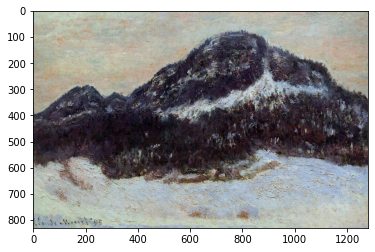

In [0]:
# show random picture from train
painter = random.choice(os.listdir(TRAIN_DIR))
subdir = TRAIN_DIR + painter + '/'
image_path = subdir + random.choice(os.listdir(subdir))

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print(painter, image.shape)
plt.imshow(image)
plt.show()

## Train generator

In [0]:
painters_to_labels, labels_to_painters = {}, {}
for i, painter in enumerate(sorted(os.listdir(TRAIN_DIR))):
    painters_to_labels[painter] = i
    labels_to_painters[i] = painter

In [0]:
painters_to_labels

{'Cezanne': 0,
 'Degas': 1,
 'Gauguin': 2,
 'Hassam': 3,
 'Matisse': 4,
 'Monet': 5,
 'Pissarro': 6,
 'Renoir': 7,
 'Sargent': 8,
 'VanGogh': 9}

In [0]:
def load_random_picture(directory):
    painter = random.choice(os.listdir(directory))
    subdir = directory + painter + '/'
    image_path = subdir + random.choice(os.listdir(subdir))
    label = painters_to_labels[painter]

    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [0]:
def generator(directory, batch_size):
    while True:
        images, labels = [], []
        for _ in range(batch_size):
            image, label = load_random_picture(directory)
            image = image / 255 - 0.5
            #print(image.shape)
            images.append(image[:, :, 0].ravel())
            labels.append(label)
        images = np.stack(images)
        #labels = keras.utils.to_categorical(labels, NUM_CLASSES)
        return images, labels

In [0]:
for images, labels in generator(TRAIN_DIR, 1):
    print(labels_to_painters[np.argmax(labels[0])])
    plt.imshow(np.clip(images[0] + 0.5, 0, 1))
    break

ValueError: ignored

In [0]:
X_train, y_train = generator(TRAIN_DIR, 3000)

In [0]:
X_test, y_test = generator(VALID_DIR, 1000)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

start = time.time()

model = LinearSVC()
model.fit(X_train, y_train)


y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

print(time.time() - start)
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

In [0]:
start = time.time()
rff = RandomFourierFeatures(kernel='gaussian')
rff.fit(X_train)

XF_train, XF_test = rff.transform(X_train), rff.transform(X_test)
model = LogisticRegression(dual=False)
model.fit(XF_train, y_train)

y_pred_train = model.predict(XF_train)
y_pred_test = model.predict(XF_test)

print(time.time() - start)
print(accuracy_score(y_train, y_pred_train))
print(accuracy_score(y_test, y_pred_test))

145.8445224761963
0.44
0.268


In [0]:
XF_train.shape

((3000, 1000),)

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.decomposition import PCA, TruncatedSVD

n_feat = [100, 200, 500, 1000]
n_dim = [50, 100, 200, 500, 1000, 2000]
test_acc = []
train_acc = []
reg_coefs = [0.7, 0.8, 0.9, 1]
new_dim = 200

ort_test_acc = []
ort_train_acc = []

for n in tqdm(range(len(n_feat))):

    pca = TruncatedSVD(n_components=new_dim).fit(X_train)
    X_trans_train = pca.transform(X_train)

    pca = TruncatedSVD(n_components=new_dim).fit(X_test)
    X_trans_test = pca.transform(X_test)

    rff = RandomFourierFeatures(kernel='cauchy', n_features=n_feat[n])
    rff.fit(X_train)

    XF_train, XF_test = rff.transform(X_train), rff.transform(X_test)
    model = LogisticRegression(dual=False)
    model.fit(XF_train, y_train)

    y_pred_train = model.predict(XF_train)
    y_pred_test = model.predict(XF_test)

    train_acc.append(accuracy_score(y_train, y_pred_train))
    test_acc.append(accuracy_score(y_test, y_pred_test))

    rff = RandomFourierFeatures(kernel='cauchy', n_features=n_feat[n])
    rff.fit(X_trans_train)

    XF_train, XF_test = rff.transform(X_trans_train), rff.transform(X_trans_test)
    model = LogisticRegression(dual=False)
    model.fit(XF_train, y_train)

    y_pred_train = model.predict(XF_train)
    y_pred_test = model.predict(XF_test)

    ort_train_acc.append(accuracy_score(y_train, y_pred_train))
    ort_test_acc.append(accuracy_score(y_test, y_pred_test))




  0%|          | 0/4 [00:00<?, ?it/s]


 25%|██▌       | 1/4 [02:54<08:42, 174.31s/it]


 50%|█████     | 2/4 [05:42<05:44, 172.49s/it]


 75%|███████▌  | 3/4 [08:19<02:47, 167.96s/it]


100%|██████████| 4/4 [11:20<00:00, 170.01s/it]


<Figure size 864x432 with 0 Axes>

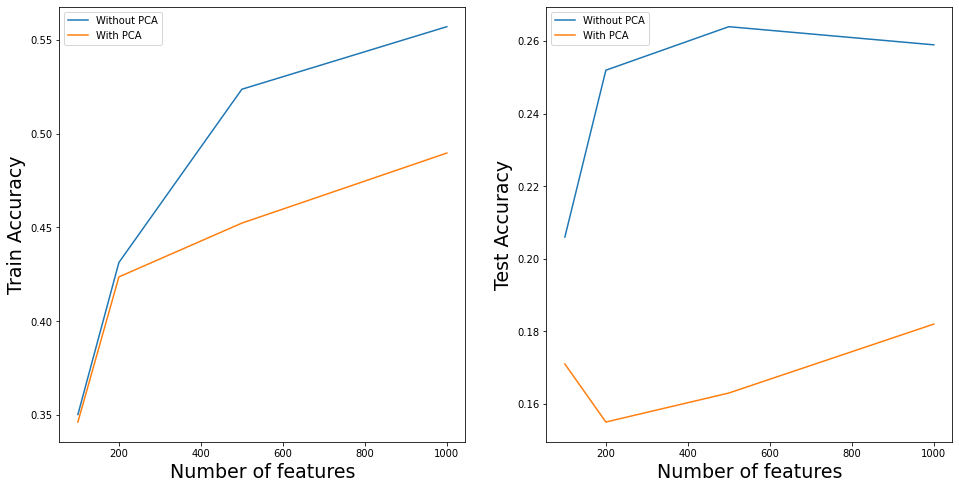

In [0]:
plt.figure(figsize=(12, 6))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.plot(n_feat, train_acc, label='Without PCA')
ax1.plot(n_feat, ort_train_acc, label='With PCA')
ax1.set_xlabel('Number of features', size=19)
ax1.set_ylabel('Train Accuracy', size=19)
ax1.legend()

ax2.plot(n_feat, test_acc, label='Without PCA')
ax2.plot(n_feat, ort_test_acc, label='With PCA')
ax2.set_xlabel('Number of features', size=19)
ax2.set_ylabel('Test Accuracy', size=19)
ax2.legend()

plt.show()
